In [1]:
import numpy as np
from utils import *

import tensorflow.keras.utils
from tensorflow.keras import backend as K
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import save_model,load_model,Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.layers import Conv2D, UpSampling2D, AveragePooling2D, MaxPooling2D, Dense,Input, Dropout
from tensorflow.keras.layers import LeakyReLU,Reshape,BatchNormalization, Flatten
from tensorflow.keras.models import save_model
from tempfile import TemporaryFile
import tensorflow as tf
import pickle
import scipy.io as sio
import matplotlib.pyplot as plt
from IPython import display
import time
from sklearn.mixture import GaussianMixture
import umap
from copy import deepcopy

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
#! pip install umap-learn


In [4]:
zdim=16 # This is the dimension of intermediate latent variable 
epochs = 10000
epochstep = epochs/100
nofclasses=10
batchsize=1000 
nofprojections = 40

## Data Generation

In [5]:
#Read MNIST

(x_train,y_train),(x_test,y_test)=mnist.load_data()
dataX_train=np.expand_dims(x_train.astype('float32')/255.,3)
dataX_test=np.expand_dims(x_test.astype('float32')/255.,3)

labelX_train = tf.keras.utils.to_categorical(y_train, nofclasses)
labelX_test = tf.keras.utils.to_categorical(y_test, nofclasses)

In [6]:
numdataTrain = labelX_train.shape[0]
numdataTest = labelX_test.shape[0]

dataX_train1 = np.reshape(dataX_train,[numdataTrain,28*28]) 
dataX_test1 = np.reshape(dataX_test,[numdataTest,28*28]) 

In [7]:
numtasks =4


dataY_train1 = {}
dataY_test1 = {}
labelY_train = {}
labelY_test = {}
indxtot = {}
for numtask in range(numtasks):
    


    idx = list(range(28 * 28))
    np.random.shuffle(idx)
     
    indxtot[numtask] = idx

    dataY_train1[numtask]= np.zeros([numdataTrain,28*28])
    temp3 = np.zeros([numdataTrain,28*28])

    dataY_test1[numtask]= np.zeros([numdataTest,28*28])
    temp4 = np.zeros([numdataTrain,28*28])

    labelY_train[numtask] =labelX_train   

    labelY_test[numtask] =  labelX_test  

    for i in range(numdataTrain):    
        temp = dataX_train1[i,:]    
        temp2 = temp[idx]        
        dataY_train1[numtask][i,:] = temp2
    
    for i in range(numdataTest):    
        temp = dataX_test1[i,:]  
        temp2 = temp[idx]        
        dataY_test1[numtask][i,:] = temp2
    
    
    

##  X is input and Z the embedding space

In [8]:

 
imgX=Input(((28*28),)) #Input image 
labelX=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot



## Encoder, Decoder and Classifier NN

In [9]:
hidden_size = 512
x=Dense(hidden_size,activation = 'relu')(imgX)
 
x=Dense(hidden_size/2,activation = 'relu')(x)
#x=Dense(hidden_size/32,activation = 'sigmoid')(x)




encodedX=Dense(zdim)(x)

encoderX=Model(inputs=[imgX],outputs=[encodedX])

  


In [10]:
z=Input((zdim,))

x=Dense(hidden_size/2,activation = 'relu')(z)
x=Dense(hidden_size,activation = 'relu')(x)


decodedX=Dense(28*28,activation = 'relu')(x)


decoderX=Model(inputs=[z],outputs=[decodedX])

  


In [11]:
probX=Dense(nofclasses,activation='softmax')(z)
classifier=Model(inputs=[z],outputs=[probX])


# Training on Task 1

In [12]:
lamda=10  

discriminationLoss=K.mean(K.categorical_crossentropy(labelX,classifier(encoderX(imgX))))
autorec = K.mean(K.square(imgX-decoderX(encoderX(imgX))))
myLoss= discriminationLoss+lamda*autorec

In [13]:
params=encoderX.weights + decoderX.weights + classifier.weights
 
    
opt = Adam(lr=1e-4)  
updates = opt.get_updates(myLoss,params)
train = K.function(inputs=[imgX,labelX],outputs=[myLoss,lamda*autorec,discriminationLoss],updates=updates)

In [14]:
loss=[]
testXperf = []

In [15]:
for itr in range(epochs):
    indTrainDataX,trainLabelX=batchGenerator(labelX_train,batchsize,nofclasses=10)
    trainDataX=dataX_train1[indTrainDataX,...]
    loss.append(train(inputs=[trainDataX,trainLabelX]))
    
    if itr%epochstep==0:

        perd_label_X = classifier.predict(encoderX.predict(dataX_test1))
        testXperf.append(100*float(sum(1*(np.argmax(perd_label_X,axis=1)==np.argmax(np.squeeze(labelX_test),axis=1))))/perd_label_X.shape[0])



Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


# Learning Next Tasks

In [16]:
testpermutedperf = {}
thres = .7
testpermutedperf[0] = testXperf
for ntask in range(numtasks):
    testpermutedperf[ntask+1] = []

GMM = {}
 


imgY=Input(((28*28),), dtype='float32') #Input image 
labelY=K.placeholder(shape=(None,nofclasses),dtype='float32') #labels of input images oneHot

imgZ=Input(((28*28),), dtype='float32') 
labelZ=K.placeholder(shape=(None,nofclasses),dtype='float32')  


lamda2=1e-3
theta=theta=tf.keras.backend.placeholder(shape = (nofprojections, zdim), dtype='float32')


discriminationLoss=K.mean(K.categorical_crossentropy(labelZ,classifier(encoderX(imgZ))))
autorec = K.mean(K.square(imgZ-decoderX(encoderX(imgZ))))

swLoss =sWasserstein(encoderX(imgY),encoderX(imgZ),theta,nofclasses,Cp=labelX,Cq=labelZ)



myLossT= discriminationLoss+lamda*autorec+lamda2*swLoss


params=encoderX.weights + decoderX.weights + classifier.weights

optT = Adam(lr=5e-5) # very important
updatesT = optT.get_updates(myLossT,params)
trainT = K.function(inputs=[imgX,imgY,imgZ,labelX,labelY,labelZ,theta],outputs=[lamda*autorec,discriminationLoss,swLoss],updates=updatesT)







/nas/home/mrostami/.local/lib/python3.7/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


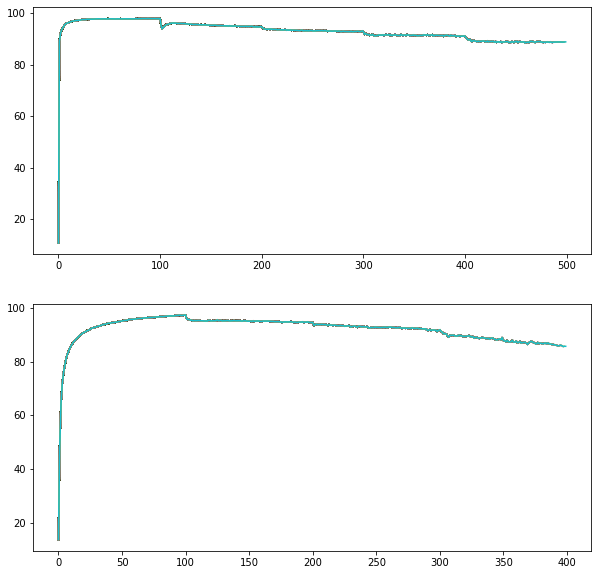

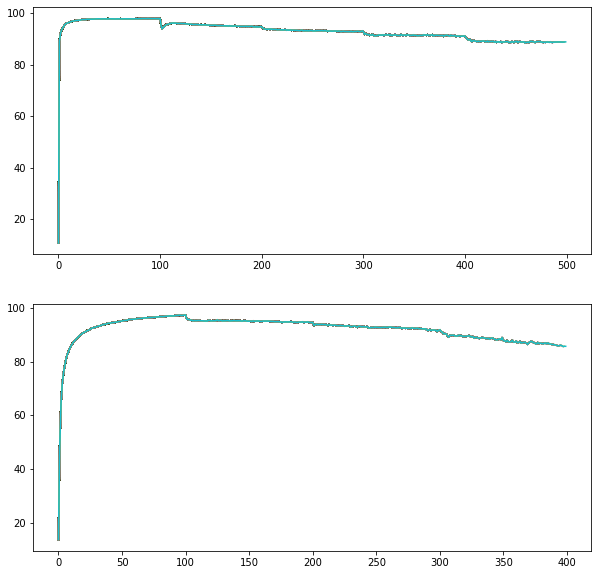

In [17]:
fig,ax=plt.subplots(2,figsize=(10,10))

for ntask in range(numtasks):
    
    
    
    #Fit GMM to training data    
    if ntask ==0:
        labelX_train_EXP = labelX_train
        dataX_train1_EXP = dataX_train1
    else: 
        labelX_train_EXP = np.concatenate((labelY_train[ntask-1],xreptrainlabelonehot ),axis=0)
        dataX_train1_EXP = np.concatenate((dataY_train1[ntask-1], xreptrainData),axis=0)
    tempvar = labelX_train_EXP
    
    num_det_clusters = 0

    labeltrain_EXP = np.argmax(np.squeeze(labelX_train_EXP),axis=1)

    # fitting GNN
    print('ntask')
    print(ntask)
    while(num_det_clusters!=nofclasses):
        encodedXtrain_EXP = encoderX.predict(dataX_train1_EXP)
        labelX_train_EXP = tempvar
        
        gmm =GaussianMixture(n_components=10,warm_start=True,covariance_type='diag',)
        gmm.fit(encodedXtrain_EXP,labelX_train_EXP   )
        
        btemp = gmm.predict_proba(encodedXtrain_EXP)

        indgmm2 = []
        for ii in range(btemp.shape[0]):
            if np.max(btemp[ii,:]) > thres:
                indgmm2.append(ii)

        encodedXtrain_EXP = encodedXtrain_EXP[indgmm2,:]
        labelX_train_EXP = labelX_train_EXP[indgmm2,:]

        gmm =GaussianMixture(n_components=10,warm_start=True,covariance_type='diag',)
        gmm.fit(encodedXtrain_EXP,labelX_train_EXP   )  
        
        
        
        labeltrain_EXP = np.argmax(np.squeeze(labelX_train_EXP),axis=1)
        
        
        
        
        
        GMM[ntask] = gmm

        labeltraingmmpredict_EXP = gmm.predict(encodedXtrain_EXP)
        labtransform = []
        for j in range(nofclasses):
            labtransform = labtransform + [round(labeltrain_EXP[labeltraingmmpredict_EXP==j].mean())]

        num_det_clusters = np.unique(labtransform, axis=0).shape[0]
        print(num_det_clusters)


    for j in range(labeltraingmmpredict_EXP.shape[0]):
        labeltraingmmpredict_EXP[j] = labtransform[labeltraingmmpredict_EXP[j]]


    ## network performance on GMM prediction
    print('GMM Perf:')

    print(100*float(sum(1*((labeltraingmmpredict_EXP)==np.argmax(np.squeeze(labelX_train_EXP),axis=1))))/labelX_train_EXP.shape[0])
    
    
    # GMM is used as a generative model so task 1 data is not saved
    xnofsample = 150000
    xreptrainDataencoded, xreptrainlabel = gmm.sample(xnofsample)
    
    
    atemp = gmm.predict_proba(xreptrainDataencoded)


    indgmm = []
    for i in range(atemp.shape[0]):
        if np.max(atemp[i,:]) > thres:
            indgmm.append(i)
    
    xreptrainDataencoded = xreptrainDataencoded[indgmm,:]
    xreptrainlabel = xreptrainlabel[indgmm]
    
    
    
    
    
    
    
    
    
    
    
    xreptrainData = decoderX.predict(xreptrainDataencoded)

    xreptrainData = xreptrainData.clip(min=0)
    xreptrainData = xreptrainData.clip(max=1)


    for j in range(xreptrainlabel.shape[0]):
        xreptrainlabel[j] = labtransform[xreptrainlabel[j]]

    xreptrainlabelonehot = tf.keras.utils.to_categorical(xreptrainlabel)

    xnofsampletest = 10000
    xreptestDataencoded, xreptestlabel = gmm.sample(xnofsampletest)
    xreptestData = decoderX.predict(xreptestDataencoded)

    xreptestData = xreptestData.clip(min=0)
    xreptestData = xreptestData.clip(max=1)


    for j in range(xnofsampletest):
        xreptestlabel[j] = labtransform[xreptestlabel[j]]
    
    xreptestlabelonehot = tf.keras.utils.to_categorical(xreptestlabel)

    # model perforamnce on generated dataset
    perd_label_Sample = classifier.predict(encoderX.predict(xreptestData))
    print('model perforamnce on generated dataset')
    print(100*float(sum(1*(np.argmax(perd_label_Sample,axis=1)==np.argmax(np.squeeze(xreptestlabelonehot),axis=1))))/perd_label_Sample.shape[0])


    
    
    
    
    batchsize=400
    batchsize = batchsize/2
    
    
    seed=np.random.randint(0,high=100)
    
  
      
    
    for itr in range(epochs):
        indTrainDataY,trainLabelY=batchGenerator(labelY_train[ntask],batchsize,nofclasses=10)
        trainDataY=dataY_train1[ntask][indTrainDataY,...]

        indTrainDatasample,trainLabelsample=batchGenerator(xreptrainlabelonehot,batchsize,nofclasses=10)
        trainDatasample=xreptrainData[indTrainDatasample,...]


        trainDataYtot = np.concatenate((trainDataY,trainDatasample), axis=0)
        trainLabelYtot = np.concatenate((trainLabelY,trainLabelsample), axis=0)


        theta_=generateTheta(nofprojections,zdim)
        

        loss.append(trainT(inputs=[trainDataY,trainDatasample,trainDataYtot,trainLabelY,trainLabelsample,trainLabelYtot,theta_]))
           
            
        if itr%epochstep==0:

            perd_label_X = classifier.predict(encoderX.predict(dataX_test1))
            testXperf.append(100*float(sum(1*(np.argmax(perd_label_X,axis=1)==np.argmax(np.squeeze(labelX_test),axis=1))))/perd_label_X.shape[0])


            for kk in range(ntask+1):

                

                perd_label_Y = classifier.predict(encoderX.predict(dataY_test1[kk]))
                testpermutedperf[kk+1].append(100*float(sum(1*(np.argmax(perd_label_Y,axis=1)==np.argmax(np.squeeze(labelY_test[kk]),axis=1))))/perd_label_Y.shape[0])






            ax[0].plot(testpermutedperf[0])
            ax[1].plot(testpermutedperf[1])
            display.clear_output(wait=True)
            display.display(plt.gcf()) 
            time.sleep(1e-3) 
            
    save_model(classifier,filepath='classifier'+str(ntask)+'.h5')
    save_model(decoderX,filepath='decoderX'+str(ntask)+'.h5')
    save_model(encoderX,filepath='encoderX'+str(ntask)+'.h5')
    


In [18]:
# testpermutedperf[-1] = testXperf
# data = testpermutedperf

Text(0, 0.5, 'Testing Accuracy')

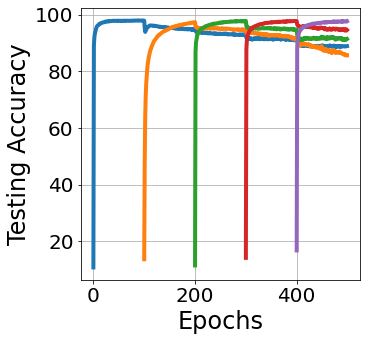

In [19]:
epochs1 = epochs/epochstep
fig, ax=plt.subplots(1,1,figsize=(5,5))
for task in range(numtasks+1):
    plt.plot(np.arange(epochs1*(task),epochs1*(numtasks+1)),testpermutedperf[task],linewidth=4)
plt.grid()
plt.tick_params(labelsize=20)

ax.set_xlabel('Epochs',fontsize=24)
ax.set_ylabel('Testing Accuracy',fontsize=24)

#ax.set_title('Training loss for the AE tasks',fontsize=14)


In [20]:
temp1 = xtrainDataToT = encoderX.predict(dataX_test1)
temp2 = xtrainDataToT = encoderX.predict(dataY_test1[0])
temp3 = xtrainDataToT = encoderX.predict(dataY_test1[1])
temp4 = xtrainDataToT = encoderX.predict(dataY_test1[2])
temp5 = xtrainDataToT = encoderX.predict(dataY_test1[3])


xtrainDataToT = np.concatenate((temp1,temp2,temp3,temp4,temp5 ), axis=0)
xtrainlabelTot = np.argmax( np.concatenate((labelX_test,labelY_test[0],labelY_test[1],labelY_test[2],labelY_test[3] ), axis=0),axis=1)


In [21]:
umapperT=umap.UMAP()
xumapT=umapperT.fit_transform(xtrainDataToT,xtrainlabelTot)


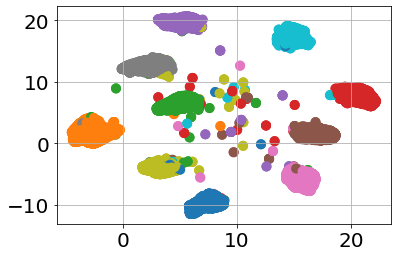

In [22]:
plt.scatter(xumapT[:,0],xumapT[:,1],c=xtrainlabelTot,cmap='tab10',linewidth=4)


plt.grid()
plt.tick_params(labelsize=20)


plt.show()


